# The comet 67P/Churyumov–Gerasimenko (iPython)*

will download the data from NASA Horizons and visualize the orbit using matplotlib.

### NASA Horizons

If you’re interested in Solar System dynamics, you have probably heard of NASA Horizons. It’s a large database of Solar System objects, their orbits and physical properties. It includes planets, moons, satellites, asteroids, comets and spacecrafts. With REBOUND, you can easily import data from NASA Horizons. For this example we load 'start_of_evolution.bin' which has the 4 major planets, the 4 TNOs from the assignment and the commet 'CG' preloaded.

In [1]:
import rebound
import os
simulation_initial_conditions = 'start_of_simulation.bin'
if not os.access(simulation_initial_conditions, os.R_OK):
    # Pull from JPL if we can, doesn't work if using binder, do to network connection issues.
    sim = rebound.Simulation()
    sim.add('Sun')
    sim.add('Jupiter', hash='Jupiter')
    sim.add('Saturn', hash='Saturn')
    sim.add('Uranus', hash='Uranus')
    sim.add('Neptune', hash='Neptune')
    sim.N_active = sim.N
    sim.add("NAME=Churyumov-Gerasimenko; CAP", hash='CG')
    sim.add('K15RR7Y', hash='K15RR7Y')
    sim.add('K13GD8G', hash='K13GD8G')
    sim.add('K15VG6A', hash='K15VG6A')
    sim.add('K14UM9M', hash='K14UM9M')
    sim.save(simulation_initial_conditions)
else:
    # now load from disk, even if we just made this file.
    sim = rebound.Simulation(simulation_initial_conditions)
sim.move_to_com()

Now all the data is in REBOUND! Let’s have a look at the orbit of Jupiter.  The planets orbits, and those of the TNOs can be accessed via their 'HASH' codes.  

The 'hash' codes in the file are 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'K15RR7Y', 'K13CD8G', 'K15VG6A', 'K14UM9M' and the comet 'CG'

In [2]:
for orbit in sim.calculate_orbits():
    print(orbit)

<rebound.Orbit instance, a=5.203729338199369 e=0.04858911083084059 inc=0.022751720021705384 Omega=1.754347534033106 omega=-1.511599544186459 f=-1.1342559443081828>
<rebound.Orbit instance, a=9.539828267959258 e=0.054964331185668396 inc=0.043423448129509455 Omega=1.982732452559683 omega=-0.3677269504100727 f=-2.5896548480825134>
<rebound.Orbit instance, a=19.19265913511889 e=0.047232403462651035 inc=0.013475096890505385 Omega=1.2916962550056916 omega=1.6913769815284079 f=-2.2957760764799477>
<rebound.Orbit instance, a=30.075658778396633 e=0.00874043422103952 inc=0.030896894047638547 Omega=2.3000583858133217 omega=-1.5271951203637442 f=-0.9454707982051334>
<rebound.Orbit instance, a=3.4252908382350316 e=0.6506599258940868 inc=0.06774299668387308 Omega=0.6362422085606589 omega=0.3922825867365728 f=-2.1370046119790764>
<rebound.Orbit instance, a=47.46465664430911 e=0.2776528798137656 inc=0.06032748881073076 Omega=-0.7129869347620346 omega=-0.2254263482586706 f=1.235440439596463>
<rebound.O

You can also use the IAU asteroid number for numbered asteroids, or the database record numbers from Horizons for objects not yet numbered by the IAU (but note that database record numbers can change as the database gets rearranged with new discoveries, see http://ssd.jpl.nasa.gov/?horizons_doc#sb for details). In our case the current database record number is 900647, so you could use sim.add("900647") to get the newest set of orbital parameters for Churyumov-Gerasimenko.

NASA Horizons doesn’t have masses for all bodies. If REBOUND doesn’t find a mass, you get a warning message (see above). In our case, we don’t need the mass of the comet (it’s really small). However, it you want, you can add it manually using the syntax sim.add("Churyumov-Gerasimenko", m=5.03e-18).

Before we integrate the orbits, let’s plot the instantaneous orbits using the built-in REBOUND function OrbitPlot.

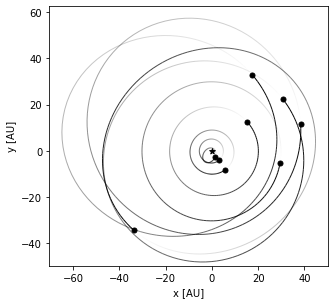

In [3]:
%matplotlib inline
fig = rebound.OrbitPlot(sim, unitlabel="[AU]")

## Integration with IAS15

We will integrate backwards in time for 70 years. Because we don’t know what will happen yet (hint: a close encounter) we will use the IAS15 integrator. It is fast, accurate and has adaptive timesteps to capture any potential close encounters.

To integrate backwards, we could set a negative timestep or multiply all velocities with −1.  We’ll choose the first option:

In [4]:
sim.dt = -0.01

While we’re integrating, let’s store the positions of Jupiter and the comet at 10000 times during the interval. We’ll need to prepare a few variables to do that:

In [5]:
import numpy as np
Noutputs = 10000
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,-80.*year, Noutputs)
x = np.zeros((2,Noutputs))
y = np.zeros((2,Noutputs))
z = np.zeros((2,Noutputs))

Now we’re ready to start the integration:

In [6]:
sim.integrator = "ias15" # IAS15 is the default integrator, so we actually don't need this line
sim.move_to_com()        # We always move to the center of momentum frame before an integration
ps = sim.particles       # ps is now an array of pointers and will change as the simulation runs

for i,time in enumerate(times):
    sim.integrate(time)
    x[0][i] = ps['Jupiter'].x   # This stores the data which allows us to plot it later
    y[0][i] = ps['Jupiter'].y
    z[0][i] = ps['Jupiter'].z
    x[1][i] = ps['CG'].x
    y[1][i] = ps['CG'].y
    z[1][i] = ps['CG'].z

### Visualization with matplotlib

Let’s plot the orbits of Jupiter (blue) and the comet (green) to get an idea of what was going on during our integration.

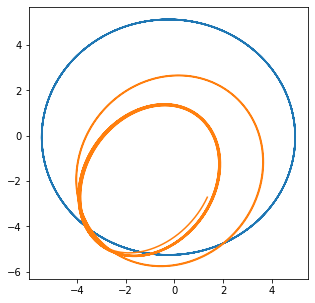

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
# ax.set_xlim([-6,6])
# ax.set_ylim([-6,6])
plt.plot(x[0], y[0]);
plt.plot(x[1], y[1]);

As you can see in the above image, the comet 67P had a rather strong encounter with Jupiter a few years ago. Of course, if you wanted to do a realistic simulation of that encounter, you’d need to include all the other planets and maybe even some non-gravitational effects for the comet. However, let’s stick with our simplistic model and try to find out when exactly the two bodies had a close encounter. We already stored the data, so we can just plot their distance as a function of time.

Minimum distance (0.052425 AU) occured at time: -61.974197 years.


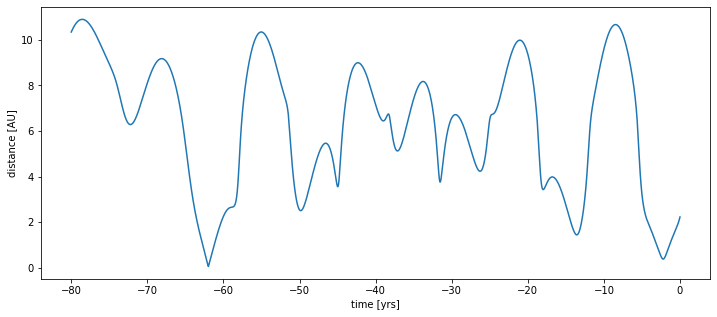

In [8]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
ax.set_xlabel("time [yrs]")
ax.set_ylabel("distance [AU]")
distance = np.sqrt(np.square(x[0]-x[1])+np.square(y[0]-y[1])+np.square(z[0]-z[1]))
plt.plot(times/year, distance);
closeencountertime = times[np.argmin(distance)]/year
print("Minimum distance (%f AU) occured at time: %f years." % (np.min(distance),closeencountertime))

We can see that the minimum distance occured approximately 56 years ago (as of writing this tutorial). Let’s see what date that was using some python magic and the datetime module:

In [9]:
import datetime
encounterdate = datetime.datetime.today() + datetime.timedelta(days=365.25*closeencountertime)
encounterdate.strftime("%Y-%m-%d %H:%M")

'1959-02-05 17:47'

If you check Wikipedia or JPL, the encounter happened on 1959-Feb-04 06:24, so we are off by a few days. It turns out that’s because of jets from the comet!